# Project | Natural Language Processing Challenge
### Fake news classifier

Environment

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

"""
import nltk
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
"""


'\nimport nltk\nnltk.download("wordnet")\nfrom nltk.corpus import stopwords\nfrom nltk.tokenize import word_tokenize\nfrom nltk.stem import PorterStemmer\nfrom nltk import pos_tag\nfrom nltk.stem import WordNetLemmatizer\nlemmatizer = WordNetLemmatizer()\nstemmer = PorterStemmer()\n'

### Load train and test data


In [13]:
train_data_raw = pd.read_csv(
    "../data/training_data_lowercase.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)
test_data_raw = pd.read_csv(
    "../data/testing_data_lowercase_nolabels.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

### quick EDA

In [14]:
# preview
display(train_data_raw.head())

# shapes
print(
    f"Training data shape (rows, columns): {train_data_raw.shape}\n"
    f"Test data shape (rows, columns): {test_data_raw.shape}"
)


# fake news / real news balance
print("\nFake news / real news balance:")
print(train_data_raw["label"].value_counts(normalize=True))

# missing values
print("\nMissing values per column:")
print(train_data_raw.isnull().sum())

# empty text check
empty_texts = (train_data_raw["text"].str.strip() == "").sum()
print(f"\nNumber of empty text entries: {empty_texts}")


,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


Training data shape (rows, columns): (34152, 2)
Test data shape (rows, columns): (9984, 2)

Fake news / real news balance:
label
0    0.514523
1    0.485477
Name: proportion, dtype: float64

Missing values per column:
label    0
text     0
dtype: int64

Number of empty text entries: 0


### Training - validation split

In [15]:
X = train_data_raw["text"]
y = train_data_raw["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=12,
    stratify=y
)

### Data cleaning

In [16]:
# removing only special characters and empty spaces
def clean_text(text):
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

X_train_clean = X_train.apply(clean_text)
X_test_clean  = X_test.apply(clean_text)

Skipping lemmatization on this model. Potential thing to try on next ones.
We chose not to apply lemmatization because:
- Anticipated a low impact based on the nature of the dataset. Not worth the cost
- We could lose nuance in text relevant to fake news style
- Lower impact of lemmatization on TF-IDF 

### Vectorization

TF-IDF

In [17]:
# using TF-IDF. Intuitively better suited for fake news detection (emphasis on presence of certain sifnigicant words rather than accumulation of certain words)

tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_features=20000
)

'''
tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    analyzer="char",
    ngram_range=(3, 5),
    max_features=20000
)
'''

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_clean)

print(f"TF-IDF train shape: {X_train_tfidf.shape}")
print(f"TF-IDF test shape: {X_test_tfidf.shape}")

TF-IDF train shape: (27321, 20000)
TF-IDF test shape: (6831, 20000)


BoW test for comparison

In [18]:
bow_vectorizer = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_features=20000
)

X_train_bow = bow_vectorizer.fit_transform(X_train_clean)
X_test_bow  = bow_vectorizer.transform(X_test_clean)

print(f"BoW train shape: {X_train_bow.shape}")
print(f"BoW test shape: {X_test_bow.shape}")

BoW train shape: (27321, 20000)
BoW test shape: (6831, 20000)


### Model training

In [19]:
#logistic regression model definition
model_logisticreg = LogisticRegression(
    max_iter=5000,
)

# TF-IDF
model_logisticreg.fit(X_train_tfidf, y_train)
# BoW
model_logisticreg.fit(X_train_bow, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

### Evaluation

TF-IDF

In [20]:
# TF-IDF
y_pred_tfidf = model_logisticreg.predict(X_test_tfidf)
y_train_pred = model_logisticreg.predict(X_train_tfidf)

print("TF-IDF Train accuracy:", accuracy_score(y_train, y_train_pred))
print("TF-IDF Validation accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("TF-IDF Classification report:")
print(classification_report(y_test, y_pred_tfidf))

TF-IDF Train accuracy: 0.9864573039054207
TF-IDF Validation accuracy: 0.9367588932806324
TF-IDF Classification report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3515
           1       0.91      0.97      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



BoW

In [21]:
# BoW
y_pred_bow = model_logisticreg.predict(X_test_bow)
y_train_bow_pred = model_logisticreg.predict(X_train_bow)

print("BoW Train accuracy:", accuracy_score(y_train, y_train_bow_pred))
print(f"BoW Accuracy on test set: {accuracy_score(y_test, y_pred_bow):.4f}\n")
print("BoW Classification report:")
print(classification_report(y_test, y_pred_bow))

BoW Train accuracy: 0.9844075985505655
BoW Accuracy on test set: 0.9404

BoW Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3515
           1       0.93      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



Confusion matrixes

<Figure size 640x480 with 0 Axes>

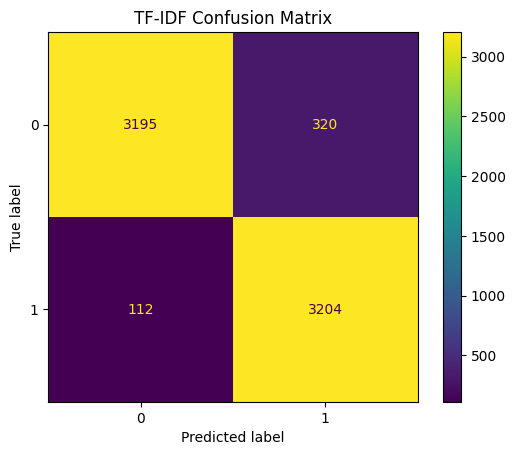

<Figure size 640x480 with 0 Axes>

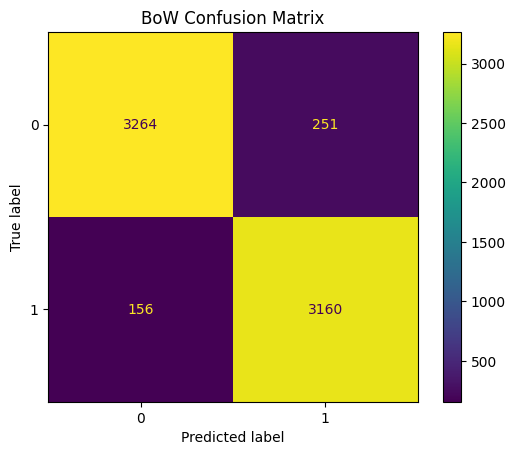

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_tfidf
)
plt.title("TF-IDF Confusion Matrix")
plt.show()

plt.figure()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_bow
)
plt.title("BoW Confusion Matrix")
plt.show()

### Interpretation

**Performance**  
Both TF-IDF and Bag-of-Words representations show high performance, with validation accuracies above 93%.

**Overfitting**  
The very high training accuracy (≈98%) and the gap between training and validation performance suggest mild overfitting.

**Comparison**  
TF-IDF shows a higher precision–recall imbalance, particularly for the fake news class, indicating a more conservative strategy when labeling something as fake news. One possible hypothesis is that TF-IDF penalizes certain terms commonly used in fake news when they appear very frequently.

**Conclusion**
We would use TF-IDF in a prediction as it has slightly worse accuracy, but not significant, and seems to be more conservative and robust with fake news predictions while keeping high levels of precision, which in our case also translates in a better chance of correctly predicting accuracy.


### Predictions


Test data preprocessing

In [23]:
# preview
display(test_data_raw.head())
print(test_data_raw.shape)

# Create X for test data and clean it with the same function as we did for training data
X_test_clean = test_data_raw["text"].apply(clean_text)

# preview
display(X_test_clean.head())

#vectorization
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)




,label,text
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...


(9984, 2)


0    copycat muslim terrorist arrested with assault...
1    wow chicago protester caught on camera admits ...
2     germany s fdp look to fill schaeuble s big shoes
3    mi school sends welcome back packet warning ki...
4    u n seeks massive aid boost amid rohingya emer...
Name: text, dtype: object

Prediction

In [24]:
test_data_raw["label"] = model_logisticreg.predict(X_test_tfidf)

# check there are only 1 and 0 in labels
test_data_raw["label"].value_counts()

label
1    5566
0    4418
Name: count, dtype: int64

Export CSV

In [25]:
test_data_raw.to_csv(
    "../predictions/predictionsModel1.csv",
    sep="\t",
    header=False,
    index=False
)

Check of export

In [26]:
predictions = pd.read_csv(
    "../predictions/predictionsModel1.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

print(f"Shape: {predictions.shape}")
predictions.head()
predictions["label"].value_counts()

Shape: (9984, 2)


label
1    5566
0    4418
Name: count, dtype: int64